In [1]:
antibiotic = "tobramycin"  # Example antibiotic, replace with actual
annotation_tool = "Kleborate" 
#new_features_interection = [2264356, 2264355, 2274080, 2274078, 2274194, 2274079, 2247530, 2247531, 2274204, 2274199, 2264353, 2274202, 2264357, 469166, 2264351, 2264354, 54372, 469181, 2274203, 469162, 2247582, 2274201, 1256360, 2273999, 469158, 2273998, 1256359, 2264358, 469169, 2376294, 1259281, 469156, 615548, 1887825, 2274192, 1759956, 1259277, 2274185, 469160, 1887826, 1477939, 2274146]
#new_features_XGBoost =  [2264356, 2264355, 2274080, 2274078, 2274194, 2274079, 2247530, 2247531, 2274204, 2274199, 2264353, 2274202, 2264357, 469166, 2264351, 2264354, 54372, 469181, 2274203, 469162, 2269721, 2247582, 2274201, 2261021, 1324580, 1302005, 1256360, 2273999, 469158, 2274000, 2273998, 1256359, 1741824, 1557116, 2274152, 2264358, 1729572, 2372038, 469169, 2045203, 2376294, 1259281, 1554735, 469156, 1259282, 2197946, 2269719, 1850398, 2372039, 2187220, 615548, 1623009, 1887825, 2274192, 2372041, 1623010, 1515517, 1759956, 1739942, 2264349, 1259277, 1884552, 367803, 1237613, 1746753, 1863150, 2268903, 1230405, 2274185, 2405594, 469160, 2372042, 1533921, 1887826, 1884719, 1885741, 1115842, 1623008, 2423490, 2261017, 1850401, 2432056, 1894456, 1932550, 937366, 2417072, 1889295, 2376293, 2269714, 1554734, 1863149, 1577572, 1635778, 1477939, 635973, 2274146, 2423429, 2198540, 2302962, 2272809]
#new_features = list(set(new_features_XGBoost) - set(new_features_interection))
new_features = [1662479]
antibiotic = antibiotic.replace('_', '/')
"""
Predicts phenotype based on annotations - minimal models

Parameters:
annotations: Path to the annotations file
phenotype: Phenotype table containing phenotypes in the same format as the BV-BRC database
Kleborate: Path to the Kleborate annotations to subset species in analysing Klebsiella pneumoniae
model: Which model to use - XGboost or ElasticNet
annotation_tool: Which annotation tool are we using for prediction - See supported tools in the README
output_path: Folder to save the output
antibipotic_classes: Antibiotic to class or subclass mapping file
genes_to_class: Genes to class mapping file for Kleborate
"""
# Replace this with actual prediction code
print("Predicts phenotype based on annotations - minimal models") 

import os
os.environ['SCIPY_ARRAY_API'] = '1'

# Now it's safe to import the libraries
import scipy
from sklearn.model_selection import train_test_split # or any other sklearn module

print("Environment variable set successfully! Imports should work now.")

import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Assuming you're using RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.metrics import sensitivity_score, specificity_score
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix


phenotype= "/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My Drive/metadata/Patric_AMR_data"
Kleborate="/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My\ Drive/metadata/concatinated_Kleborate.txt"
model="XGBoost"
antibipotic_classes="/Users/kvk22/Downloads/Drugs_per_class.csv"
genes_to_class="/Users/kvk22/Downloads/Kleborate_class_to_columns.csv"
annotations=f"/Users/kvk22/Downloads/{annotation_tool}_annotations.csv"

AMR = pd.read_csv(phenotype)
annotations = pd.read_csv(annotations, low_memory=False)
antibiotic_classes = pd.read_csv(antibipotic_classes)
if Kleborate == True: 
    Kleb = pd.read_csv(Kleborate, delimiter = "\t")
    Kleb = Kleb[Kleb["species"] == "Klebsiella pneumoniae"]
    Kleb["strain"] = Kleb["strain"].astype(str)
    AMR["Genome ID"] = AMR["Genome ID"].astype(str)
    AMR = AMR[AMR["Genome ID"].isin(Kleb["strain"])]
else:
        AMR["Genome ID"] = AMR["Genome ID"].astype(str)
antibiotics = list(np.unique(AMR["Antibiotic"]))
antibiotics = list(np.unique(AMR["Antibiotic"]))
genes_to_class = pd.read_csv(genes_to_class)
antibiotics = [antibiotic]
for antibiotic in antibiotics:
    #format amr file so it matches the corresponding antibiotic
    AMR_subset = AMR[AMR["Antibiotic"]==antibiotic]
    AMR_subset.loc[:, "Genome ID"] = AMR_subset["Genome ID"].astype(str)
    AMR_subset = AMR_subset[["Genome ID", "Resistant Phenotype"]]
    AMR_subset["Resistant Phenotype"] = np.where(AMR_subset["Resistant Phenotype"] == 'Susceptible', 0, 1)
    #extract class 
    if annotation_tool == "RGI":
        annotations["Genome.ID"] = annotations["Genome.ID"].str.replace('.fna$', '', regex=True)
        #extract class 
        if '/' in antibiotic:
            antibiotic = antibiotic.split('/')
            genes1 = list(set(annotations[annotations["Antibiotic"].str.contains(antibiotic[0], case=False, na=False)]["Best_Hit_ARO"]))
            genes2 = list(set(annotations[annotations["Antibiotic"].str.contains(antibiotic[1], case=False, na=False)]["Best_Hit_ARO"]))
            genes = genes1 + genes2
        else:
            genes = list(set(annotations[annotations["Antibiotic"].str.contains(antibiotic, case=False, na=False)]["Best_Hit_ARO"]))
        RGI_subset = annotations[["Best_Hit_ARO","Genome.ID","Best_Identities"]]
        RGI_subset = RGI_subset.drop_duplicates(subset=["Genome.ID", "Best_Hit_ARO"])
        RGI_subset = RGI_subset.dropna()
        df_pivot = RGI_subset.pivot(index="Genome.ID", columns="Best_Hit_ARO", values="Best_Identities")
        df_pivot = df_pivot.notna().astype(int)
        df_pivot = df_pivot[genes]
        merged = pd.merge(df_pivot, AMR_subset, left_on= df_pivot.index, right_on = "Genome ID", how = "inner")
    
    elif annotation_tool == "AMRFinder":
        antibiotic_classes_subset = antibiotic_classes[antibiotic_classes["Drugs"]==antibiotic]
        antibiotic_classes_subset = list(set(antibiotic_classes_subset["Subclass"]))
        annotations.loc[:, "Contig id"] = annotations["Contig id"].astype(str)
        amr_finder_drug = annotations[annotations["Contig id"].isin(AMR_subset["Genome ID"])]
        genes = list(set(amr_finder_drug[amr_finder_drug["Subclass"].isin(antibiotic_classes_subset)]["Gene symbol"]))
        amr_finder_drug = amr_finder_drug[["Contig id","Gene symbol","% Identity to reference sequence"]]
        amr_finder_drug_change = amr_finder_drug.drop_duplicates(subset=["Contig id", "Gene symbol"])
        df_pivot = amr_finder_drug_change.pivot(index="Contig id", columns="Gene symbol", values="% Identity to reference sequence")
        df_pivot = df_pivot.notna().astype(int)
        df_pivot = df_pivot[genes]
        merged = pd.merge(df_pivot, AMR_subset, left_on= df_pivot.index, right_on = "Genome ID", how = "inner")
    
    elif annotation_tool == annotation_tool == "ResFinder":
        antibiotic_classes_subset = antibiotic_classes[antibiotic_classes["Drugs"] == antibiotic]
        antibiotic_classes_subset = list(set(antibiotic_classes_subset["Subclass"]))
        antibiotic_classes_subset = [x.lower() for x in antibiotic_classes_subset]
        annotations["Genome.ID"] = annotations["Genome.ID"].str.replace('.fna$', '', regex=True)
        annotations.loc[:, "Genome.ID"] = annotations["Genome.ID"].astype(str)
        ResFinder_drug = annotations[annotations["Genome.ID"].isin(AMR_subset["Genome ID"])]
        AMR_subset = AMR_subset[AMR_subset["Genome ID"].isin(ResFinder_drug["Genome.ID"])]
        if '/' in antibiotic:
            antibiotic = antibiotic.split('/')
            genes1 = list(set(ResFinder_drug[ResFinder_drug["Phenotype"].str.contains(antibiotic[0], case=False, na=False)]["Resistance gene"]))
            genes2 = list(set(ResFinder_drug[ResFinder_drug["Phenotype"].str.contains(antibiotic[1], case=False, na=False)]["Resistance gene"]))
            genes = genes1 + genes2
        else:
            genes = list(set(ResFinder_drug[ResFinder_drug["Phenotype"].str.contains(antibiotic, case=False, na=False)]["Resistance gene"]))
        ResFinder_drug = ResFinder_drug[["Genome.ID","Resistance gene","Identity"]]
        ResFinder_drug = ResFinder_drug.drop_duplicates(subset=["Genome.ID", "Resistance gene"])
        df_pivot_res_finder = ResFinder_drug.pivot(index="Genome.ID", columns="Resistance gene", values="Identity")
        df_pivot_res_finder = df_pivot_res_finder.notna().astype(int)
        df_pivot_res_finder = df_pivot_res_finder[genes]

        merged = pd.merge(df_pivot_res_finder, AMR_subset, left_on= df_pivot_res_finder.index, right_on = "Genome ID", how = "right")
        #print(merged)

    elif annotation_tool == "DeepARG":
        antibiotic_classes_subset = antibiotic_classes[antibiotic_classes["Drugs"] == antibiotic]
        antibiotic_classes_subset = list(set(antibiotic_classes_subset["Subclass"]))
        antibiotic_classes_subset = [x.lower() for x in antibiotic_classes_subset]
        annotations["Genome.ID"] = annotations["Genome.ID"].str.replace('.fna$', '', regex=True)
        annotations.loc[:, "Genome ID"] = annotations["Genome ID"].astype(str)
        DeepARG_drug = annotations[annotations["Genome.ID"].isin(AMR_subset["Genome ID"])]
        genes = list(set(DeepARG_drug[DeepARG_drug["predicted_ARG-class"].isin(antibiotic_classes_subset)]["best-hit"]))
        genes_multiclass = list(DeepARG_drug[DeepARG_drug["predicted_ARG-class"]=="multidrug"]["best-hit"])
        genes = genes + genes_multiclass
        genes = list(set([x.split('|')[-1] for x in genes]))
        DeepARG_drug = DeepARG_drug[["Genome.ID","best-hit","probability"]]
        DeepARG_drug["best-hit"] = DeepARG_drug["best-hit"].str.split('|').str[-1]
        DeepARG_drug = DeepARG_drug.drop_duplicates(subset=["Genome.ID", "best-hit"])
        df_pivot = DeepARG_drug.pivot(index="Genome.ID", columns="best-hit", values="probability")
        df_pivot = df_pivot.notna().astype(int)
        df_pivot = df_pivot[genes]
        merged = pd.merge(df_pivot, AMR_subset, left_on= df_pivot.index, right_on = "Genome ID", how = "inner")

    elif annotation_tool == "StarAMR":
        annotations["Isolate ID"] = annotations["Isolate ID"].str.replace('.fna$', '', regex=True)
        annotations.loc[:, "Isolate ID"] = annotations["Isolate ID"].astype(str)
        if '/' in antibiotic:
            antibiotic = antibiotic.split('/')
            genes1 = list(set(annotations[annotations["CGE Predicted Phenotype"].str.contains(antibiotic[0], case=False, na=False)]["Data"]))
            genes2 = list(set(annotations[annotations["CGE Predicted Phenotype"].str.contains(antibiotic[1], case=False, na=False)]["Data"]))
            genes = genes1 + genes2
        else:
            genes = list(set(annotations[annotations["CGE Predicted Phenotype"].str.contains(antibiotic, case=False, na=False)]["Data"]))
        StarAMR_subset = annotations[["Data","Isolate ID","%Identity"]]
        StarAMR_subset = StarAMR_subset.drop_duplicates(subset=["Isolate ID", "Data"])
        df_pivot = StarAMR_subset.pivot(index="Isolate ID", columns="Data", values="%Identity")
        df_pivot = df_pivot.notna().astype(int)
        df_pivot = df_pivot[genes]
        merged = pd.merge(df_pivot, AMR_subset, left_on= df_pivot.index, right_on = "Genome ID", how = "inner")
    
    elif annotation_tool == "SraX":
        annotations["Genome.ID"] = annotations["Genome.ID"].str.replace('.fna$', '', regex=True)
        annotations.loc[:, "Genome.ID"] = annotations["Genome.ID"].astype(str)
        antibiotic_classes_subset = antibiotic_classes[antibiotic_classes["Drugs"] == antibiotic]
        antibiotic_classes_subset["Subclass"] = antibiotic_classes_subset["Subclass"].str.lower()
        annotations["Drug class"]= annotations["Drug class"].str.lower()
        SraX_subset = annotations[annotations["Genome.ID"].isin(AMR_subset["Genome ID"])]
        mask = SraX_subset["Drug class"].isin(antibiotic_classes_subset["Subclass"])
        genes = SraX_subset[mask]["ARG"]
        SraX_subset = SraX_subset[["Genome.ID","Identity (%)", "ARG"]]
        SraX_subset = SraX_subset.drop_duplicates(subset=["Genome.ID", "ARG"])
        SraX_subset = SraX_subset.pivot(index="Genome.ID", columns="ARG", values="Identity (%)")
        SraX_subset = SraX_subset.notna().astype(int)
        SraX_subset = SraX_subset[list(set(genes))]
        merged = pd.merge(SraX_subset,AMR_subset, left_on =  SraX_subset.index,right_on = "Genome ID", how = "inner")

    elif annotation_tool == "Abricate":
        annotations["#FILE"] = annotations["#FILE"].str.replace('.fna$', '', regex=True)
        annotations.loc[:, "#FILE"] = annotations["#FILE"].astype(str)
        antibiotic_classes_subset = antibiotic_classes[antibiotic_classes["Drugs"] == antibiotic]
        antibiotic_classes_subset["Subclass"] = antibiotic_classes_subset["Subclass"].str.lower()
        Abrikate_subset = annotations[annotations["RESISTANCE"].str.contains('|'.join(antibiotic_classes_subset["Subclass"]), na=False)]
        Abrikate_subset.rename(columns={'#FILE': 'Genome.ID'}, inplace=True)
        Abrikate_subset = Abrikate_subset[["Genome.ID","%IDENTITY", "GENE"]]
        Abrikate_subset = Abrikate_subset.drop_duplicates(subset=["Genome.ID", "GENE"])
        Abrikate_subset = Abrikate_subset.pivot(index="Genome.ID", columns="GENE", values="%IDENTITY")
        Abrikate_subset = Abrikate_subset.notna().astype(int)
        merged = pd.merge(Abrikate_subset,AMR_subset, left_on =  Abrikate_subset.index,right_on = "Genome ID", how = "inner")

    elif annotation_tool == "Kleborate":
        print(antibiotic)
        antibipotic_classes_frame = pd.read_csv(antibipotic_classes)
        merge_antibiotic_classes = pd.merge(antibipotic_classes_frame, genes_to_class, left_on = "Subclass", right_on = "Antibiotic", how = "inner")
        resistances = annotations.set_index('strain')
        arr = resistances.values
        flat_list = arr.flatten().tolist()
        split_values = [item.split(';') for item in flat_list]
        split_values = [item for sublist in split_values for item in sublist]
        split_values = list(set(split_values))
        merge_antibiotic_class = list(set(merge_antibiotic_classes[merge_antibiotic_classes["Drugs"] == antibiotic]["Kleborate_genes"]))
        set_class = resistances[merge_antibiotic_class]
        array_to_add = set_class.values
        flat_list = array_to_add.flatten().tolist()
        split_values = [item.split(';') for item in flat_list]
        split_values = [item for sublist in split_values for item in sublist]
        split_values = list(set(split_values))
        # Assuming resistances is a DataFrame and resistances.index gives the index
        df_class = pd.DataFrame(index=resistances.index, columns=split_values)
        for index, row in resistances.iterrows():
            row_values = [item.split(';') for item in row.values]
            row_values = [item for sublist in row_values for item in sublist]
            for col in df_class.columns:
                if col in row_values:
                    df_class.loc[index,col] = 1
                else: 
                    df_class.loc[index,col] = 0
        AMR_subset = AMR[AMR["Antibiotic"]==antibiotic]
        AMR_subset["Genome ID"] = AMR_subset["Genome ID"].astype(str)
        df_class.index = df_class.index.astype(str)
        AMR_subset = AMR_subset[AMR_subset["Genome ID"].isin(df_class.index)]
        AMR_subset = AMR_subset[["Genome ID", "Resistant Phenotype"]]
        AMR_subset["Resistant Phenotype"] = np.where(AMR_subset["Resistant Phenotype"] == 'Susceptible', 0, 1)
        Kleborate_antibiotic = df_class[df_class.index.isin(AMR_subset["Genome ID"])]
        merged = pd.merge(Kleborate_antibiotic,AMR_subset, left_on =  Kleborate_antibiotic.index,right_on = "Genome ID", how = "inner")
        
    df = pd.DataFrame(columns=["antibiotic", "AMR features", "AUC", "sensitivity", "specificity"])
    #start predictions
    if len(merged.columns) >2:
        X = merged.drop(['Resistant Phenotype','Genome ID'], axis=1)
        y = merged['Resistant Phenotype']
        skf = StratifiedKFold(n_splits=5)
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            y_train = np.array(y_train)
            y_test = np.array(y_test)
            if model == "XGBoost":
                model = XGBClassifier(random_state=42, max_depth = 3, n_estimators = 30, eval_metric='logloss')
            elif model == "LASO":
                model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=10)
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            AUC = roc_auc_score(y_test, y_pred)
            sensitivity = sensitivity_score(y_test, y_pred)
            specificity = specificity_score(y_test, y_pred)
            #print(f"{antibiotic}, Known AMR features , {AUC}, {sensitivity}, {specificity}")
            rows = [{"antibiotic": antibiotic, "AMR features": "Known AMR features", "AUC": AUC, "sensitivity": sensitivity, "specificity": specificity}]
            print(f"{antibiotic}, Minimal model, {AUC}, {sensitivity}, {specificity}")
            df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)

    if new_features != None:
        #open the matrix of features
        replicating_features =  [int(feature) for feature in new_features]
        all_features = set(range(0,5458393))
        rows_to_skip = all_features - set(replicating_features)
        rows_to_skip = rows_to_skip 
        rows_to_skip = list(rows_to_skip)
        rows_to_skip = [x+1 for x in rows_to_skip]            
        replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
        replicating_features_frame = replicating_features_frame.T
        for feature in new_features:
            print(feature)
            #replicating_features_frame_subset = replicating_features_frame
            replicating_features_frame_subset = pd.DataFrame(replicating_features_frame[feature])
            #replicating_features_frame_subset = replicating_features_frame
            #print(f"Running {replicating_features} and loaded columns {replicating_features_frame.index}")
            replicating_features_frame_subset.index = replicating_features_frame_subset.index.str.replace(".fna", "", regex=False)
            df_pivot_res_finder_new = pd.merge(replicating_features_frame_subset, merged, left_index=True, right_on=["Genome ID"], how = "right")
            df_pivot_res_finder_new = df_pivot_res_finder_new.dropna(subset=[feature])
            #merged = pd.merge(df_pivot_res_finder_new, AMR_subset, left_on= df_pivot_res_finder_new.index, right_on = "Genome ID", how = "right")
            #start predictions
            if len(df_pivot_res_finder_new.columns) >2:
                X = df_pivot_res_finder_new.drop(['Resistant Phenotype','Genome ID'], axis=1)
                y = df_pivot_res_finder_new['Resistant Phenotype']
                skf = StratifiedKFold(n_splits=5)
                for i, (train_index, test_index) in enumerate(skf.split(X, y)):
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                    X_train.columns = X_train.columns.astype(str) 
                    columns = X_train.columns
                    X_test.columns = X_test.columns.astype(str) 
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test)
                    y_train = np.array(y_train)
                    y_test = np.array(y_test)
                    if model == "XGBoost":
                        model = XGBClassifier(random_state=42, max_depth = 3, n_estimators = 30, eval_metric='logloss',seed = 1024)
                    elif model == "LASO":
                        model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=10)
                    model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    AUC = roc_auc_score(y_test, y_pred)
                    sensitivity = sensitivity_score(y_test, y_pred)
                    specificity = specificity_score(y_test, y_pred)
                    #print(f"{antibiotic}, {str(replicating_features_frame.columns[0])}, {AUC}, {sensitivity}, {specificity}")
                    rows = [{"antibiotic": antibiotic, "AMR features": str(replicating_features_frame_subset.columns[0]), "AUC": AUC, "sensitivity": sensitivity, "specificity": specificity}]
                    df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
                    import shap
                    #explainer = shap.TreeExplainer(model,X_test, feature_names=columns)
                    #shap_values = explainer(X_test)
                    #shap.plots.beeswarm(shap_values)
                    #print(rows)


Predicts phenotype based on annotations - minimal models
Environment variable set successfully! Imports should work now.
tobramycin


/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_15902/4268829077.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMR_subset["Genome ID"] = AMR_subset["Genome ID"].astype(str)
/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_15902/4268829077.py:267: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)


tobramycin, Minimal model, 0.8965759849906191, 0.9085365853658537, 0.8846153846153846
tobramycin, Minimal model, 0.824577861163227, 0.8414634146341463, 0.8076923076923077
tobramycin, Minimal model, 0.8483650495845617, 0.8780487804878049, 0.8186813186813187
tobramycin, Minimal model, 0.8873046085433232, 0.9237804878048781, 0.850828729281768
tobramycin, Minimal model, 0.809691837214773, 0.8501529051987767, 0.7692307692307693
1662479


In [3]:
subset_amr_file_IDs = list(first_amr_file[first_amr_file["Genome ID"].isin(genomes["Genome ID"])]["Genome ID"])
# Write entries from subset_amr_file_IDs to genomes.txt, one per line
with open("genomes.txt", "w") as f:
    for entry in subset_amr_file_IDs:
        f.write(f"{entry}\n")


NameError: name 'first_amr_file' is not defined

In [25]:
new_features = [469122, 2268552, 1541138, 78741, 1587257, 1587259, 1587262, 1324996, 1324997, 1324998, 1324999, 1325001, 1325002, 1325003, 1325004, 1325005, 1325007, 1325008, 1325009, 1325010, 1325011, 1325012, 1325013, 1325014, 2268888, 2268249, 2268250, 2268889, 1325027, 1325028, 1898599, 1677290, 1677291, 1894129, 2273651, 2268538, 469116, 2268158]    
new_features_1 = [1325011, 1325028, 2268888, 1325002, 1325008, 1325007, 1324997, 1324998, 78741, 1325012, 1325027, 2268889, 469116, 78740, 1894129, 1325005, 2268250, 1325004, 1324996, 1677291, 1325001, 2273651, 1325010, 1577558, 1325013, 1321443, 2268538, 1587257, 2268158, 1529304, 1325009, 2273649, 2268249, 1325014, 1898599, 1743062]
len(set(new_features).intersection(set(new_features_1)))

30

In [2]:
#Check for sifnificant difference
def test_significance (minimal_model):
    import pandas as pd
    from scipy.stats import ttest_ind
    from scipy.stats import mannwhitneyu

    #print(minimal_model)
    results = pd.DataFrame(columns=['Feature Genomic', 'Metric', 'p-value', 'Significance'])
    for feature_genomic in set(minimal_model['AMR features']):
        # Separate the groups
        known_amr = minimal_model[minimal_model['AMR features'] == 'Known AMR features']
        other_genes = minimal_model[minimal_model['AMR features'] == feature_genomic]
        # Perform pairwise T-tests for AUC, sensitivity, and specificity
        for feature in ['AUC', 'sensitivity', 'specificity']:
            u_stat, p_value = mannwhitneyu(known_amr[feature], other_genes[feature], alternative='two-sided')
            if p_value < 0.05:
                row = [feature_genomic, feature, p_value, '***']
                print(f'Known AMR genes/{feature_genomic}, {feature}, {p_value}, ***') 
                results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)           
            else:
                row = [feature_genomic, feature, p_value, 'ns']
                print(f'Known AMR genes/{feature_genomic}, {feature}, {p_value}, ns')
                results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
        
    return results

In [ ]:
test_results = test_significance(df)

Known AMR genes/1855753, AUC, 0.09523809523809523, ns
Known AMR genes/1855753, sensitivity, 0.834035229790992, ns
Known AMR genes/1855753, specificity, 0.30952380952380953, ns
Known AMR genes/1855604, AUC, 0.09523809523809523, ns
Known AMR genes/1855604, sensitivity, 0.834035229790992, ns
Known AMR genes/1855604, specificity, 0.2222222222222222, ns
Known AMR genes/1894245, AUC, 0.09523809523809523, ns
Known AMR genes/1894245, sensitivity, 1.0, ns
Known AMR genes/1894245, specificity, 0.2948019919337048, ns
Known AMR genes/Known AMR features, AUC, 1.0, ns
Known AMR genes/Known AMR features, sensitivity, 1.0, ns
Known AMR genes/Known AMR features, specificity, 1.0, ns


/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_3780/3450565966.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)


In [3]:
significant_features = list(test_results[test_results['Significance'] == '***']['Feature Genomic'])
significant_features = [int(i) for i in significant_features]
significant_features

NameError: name 'test_results' is not defined

In [4]:
#Check for sifnificant difference
def means (minimal_model):
    import pandas as pd
    from scipy.stats import ttest_ind
    for i, feature_genomic in enumerate(set(minimal_model['AMR features'])):
        # Separate the groups
        if i ==0:
            known_amr = minimal_model[minimal_model['AMR features'] == 'Known AMR features']
            print(list( known_amr[['AUC', 'sensitivity', 'specificity']].mean()))
        other_genes = minimal_model[minimal_model['AMR features'] == feature_genomic]
        # Perform pairwise T-tests for AUC, sensitivity, and specificity
        print(feature_genomic, list(other_genes[['AUC', 'sensitivity', 'specificity']].mean()))

In [5]:
means(df)

[0.8533030682993008, 0.880396434698292, 0.8262097019003096]
Known AMR features [0.8533030682993008, 0.880396434698292, 0.8262097019003096]
1662479 [0.8375117588934371, 0.8794996751137102, 0.795523842673164]


In [69]:
def plot_new_variants(X, model,columns):
    import shap
    import matplotlib.pyplot as plt
    X = pd.DataFrame(X)
    X.columns = columns
    # Create a SHAP explainer
    explainer = shap.Explainer(model, X)
    # Compute SHAP values
    shap_values = explainer(X)
    # Summary plot of SHAP values
    shap.summary_plot(shap_values, X)


In [ ]:
shap_values = pd.DataFrame(shap_values.values, columns=columns)
shap_values

In [ ]:
import pandas as pd

# Define the file path
file_path = "/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My Drive/Scripts/Philogeny_aware_ML/proofs/map_unitig_to_gene_name_cefepime.txt"

# Initialize an empty list to store processed lines
data = []

# Read and process lines from the file
with open(file_path, 'r') as file:
    for line in file:
        # Remove "Original feature " from the beginning of the line
        cleaned_line = line.replace("Original feature ", "", 1).strip()
        
        # Split the line by ", "
        split_line = cleaned_line.split(", ")
        split_line[0] = split_line[0].replace(",", "", 1).strip()
        
        # Append the processed line to the data list
        data.append(split_line)

# Convert the list of processed lines into a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

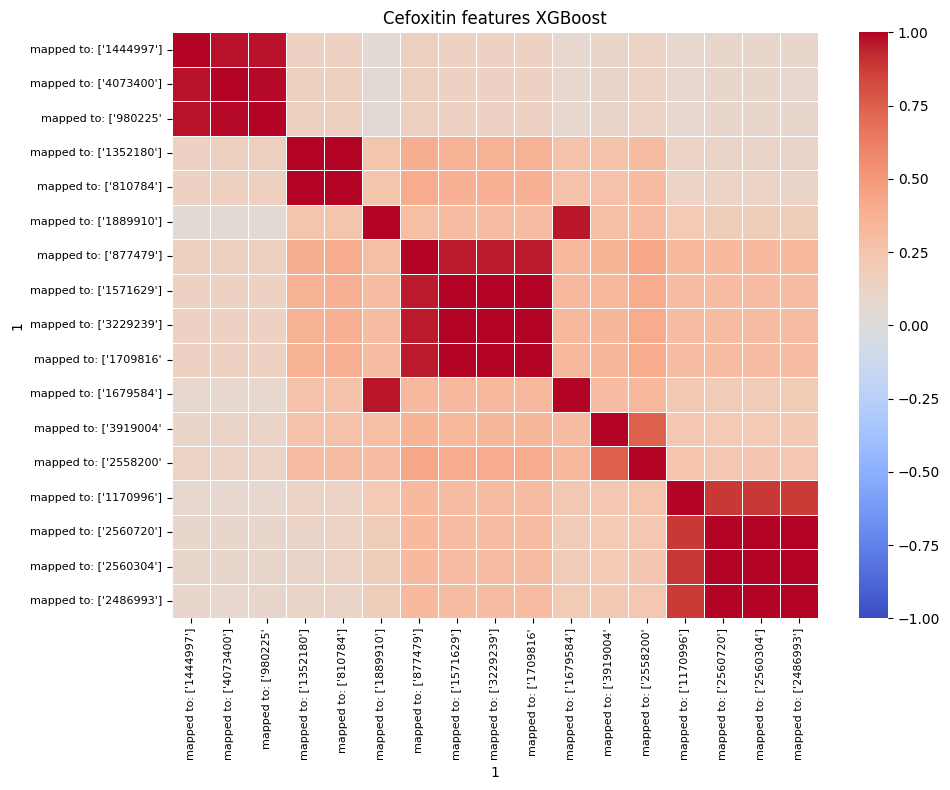

In [40]:
import pandas as pd

# Define the file path
file_path = "/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My Drive/Scripts/Philogeny_aware_ML/proofs/map_unitig_to_gene_name_cefuroxime.txt"

# Initialize an empty list to store processed lines
data = []

# Read and process lines from the file
with open(file_path, 'r') as file:
    for line in file:
        # Remove "Original feature " from the beginning of the line
        cleaned_line = line.replace("Original feature ", "", 1).strip()
        
        # Split the line by ", "
        split_line = cleaned_line.split(", ")
        split_line[0] = split_line[0].replace(",", "", 1).strip()
        
        # Append the processed line to the data list
        data.append(split_line)

# Convert the list of processed lines into a DataFrame
df = pd.DataFrame(data)

#plot correlations
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
replicating_features = list(df[0])
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")

df[0] = df[0].astype(int)
df = df[df[0].duplicated(keep=False) == False]
df_reordered = df.set_index(0).reindex(replicating_features_frame.index).reset_index()
df_reordered[1] = df_reordered[1].fillna(df_reordered['ps'])
replicating_features_frame.index = df_reordered[1]

correlation_matrix = replicating_features_frame.T.corr()

# Compute linkage and get optimal ordering
#linkage_result = linkage(correlation_matrix, method='average')
#optimal_order = leaves_list(linkage_result)

# Reorder the correlation matrix
#ordered_corr = correlation_matrix.iloc[optimal_order, optimal_order]

# Plot the heatmap without dendrograms
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.index
)
ax.set_xticks(np.arange(len(correlation_matrix.columns)) + 0.5)
ax.set_yticks(np.arange(len(correlation_matrix.index)) + 0.5)
ax.set_xticklabels(correlation_matrix.columns, fontsize=8, rotation=90)
ax.set_yticklabels(correlation_matrix.index, fontsize=8, rotation=0)
plt.title('Cefoxitin features XGBoost')
#plt.title('Ceftriaxone features XGBoost')

plt.tight_layout()
plt.show()

In [26]:
replicating_features_frame

,1328383.3.fna,1328384.3.fna,1328385.3.fna,1328386.3.fna,1328387.3.fna,1328398.3.fna,1328399.3.fna,1328401.3.fna,1328404.3.fna,1328405.3.fna,...,72407.692.fna,72407.695.fna,72407.697.fna,72407.698.fna,72407.703.fna,72407.704.fna,72407.705.fna,72407.706.fna,72407.716.fna,72407.732.fna
1,,,,,,,,,,,,,,,,,,,,,
1115842,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,0,0
1324580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1533921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
aw f,0,0,0,0,0,0,1,1,1,1,...,1,1,0,0,0,0,1,1,0,0
cfb,0,0,0,0,0,0,1,1,1,1,...,1,1,0,0,0,0,1,1,0,0
1885741,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1894456,0,0,0,1,0,1,1,1,1,0,...,0,0,0,1,1,0,0,0,0,0
2264349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2272809,1,0,0,1,0,0,1,1,1,1,...,0,0,0,0,1,1,0,0,0,0


In [ ]:
row_of_interest = pd.DataFrame(replicating_features_frame.loc[2272809]).T
list(row_of_interest.columns[(row_of_interest == 1).any(axis=0)])

['1328386.3.fna',
 '1328410.3.fna',
 '1438708.3.fna',
 '1438709.3.fna',
 '1438711.3.fna',
 '1438712.3.fna',
 '1438713.3.fna',
 '1438715.3.fna',
 '1438717.3.fna',
 '1438718.3.fna',
 '1438719.3.fna',
 '1438720.3.fna',
 '1438722.3.fna',
 '1438723.3.fna',
 '1438724.3.fna',
 '1438725.3.fna',
 '1438726.3.fna',
 '1438728.3.fna',
 '1438729.3.fna',
 '1438731.3.fna',
 '1438732.3.fna',
 '1438733.3.fna',
 '1438734.3.fna',
 '1438735.3.fna',
 '1438736.3.fna',
 '1438738.3.fna',
 '1438739.3.fna',
 '1438740.3.fna',
 '1438741.3.fna',
 '1438742.3.fna',
 '1438743.3.fna',
 '1438744.3.fna',
 '1438745.3.fna',
 '1438746.3.fna',
 '1438747.3.fna',
 '1438748.3.fna',
 '1438750.3.fna',
 '1438751.3.fna',
 '1438752.3.fna',
 '1438753.3.fna',
 '1438756.3.fna',
 '1438757.3.fna',
 '1438758.3.fna',
 '1438759.3.fna',
 '1438760.3.fna',
 '1438761.3.fna',
 '1438762.3.fna',
 '1438763.3.fna',
 '1438764.3.fna',
 '1438765.3.fna',
 '1438766.3.fna',
 '1438767.3.fna',
 '1438768.3.fna',
 '1438769.3.fna',
 '1438770.3.fna',
 '1438771.

In [240]:
replicating_features_frame

,1328383.3.fna,1328384.3.fna,1328385.3.fna,1328386.3.fna,1328387.3.fna,1328398.3.fna,1328399.3.fna,1328401.3.fna,1328404.3.fna,1328405.3.fna,...,72407.692.fna,72407.695.fna,72407.697.fna,72407.698.fna,72407.703.fna,72407.704.fna,72407.705.fna,72407.706.fna,72407.716.fna,72407.732.fna
1,,,,,,,,,,,,,,,,,,,,,
Illumina control,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
blaNDM-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
blaNDM-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
blaNDM-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
blaNDM-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
blaNDM-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
dnaA (not in strat/model improvement),0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0
bacteriophage antitermination protein Q (not in strat),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bacteriophage antitermination protein Q (not in strat),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_30351/183137285.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

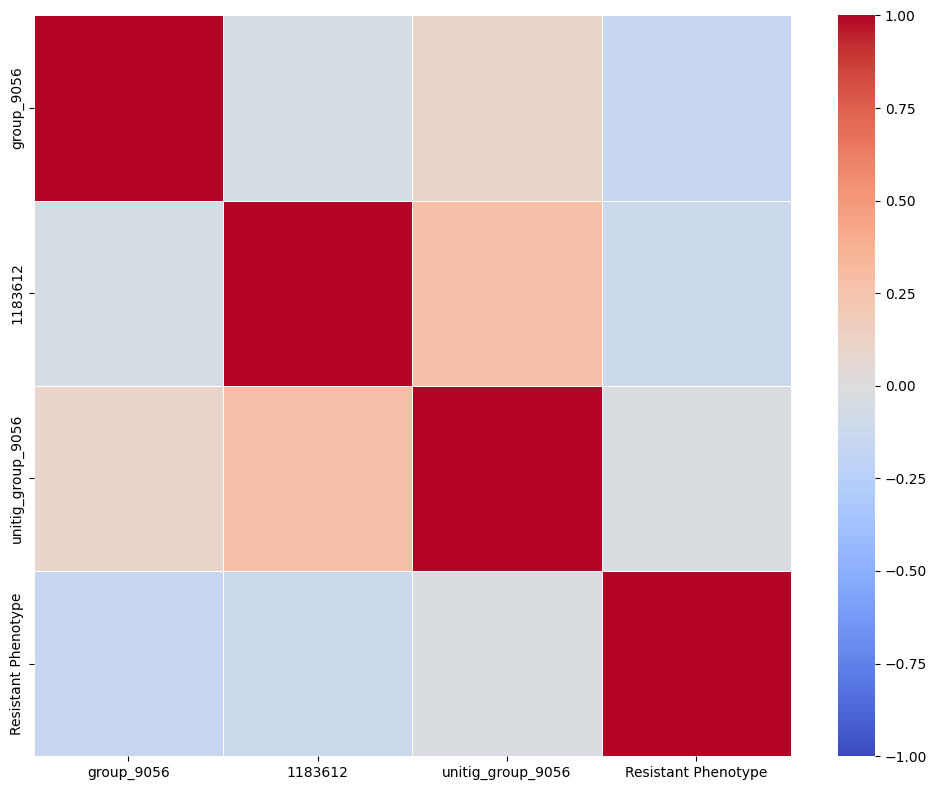

In [323]:
#find the feature in other samples 
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
columns_with_entry = gene_presence_absence.columns[gene_presence_absence.isin(["AFGFLFJD_05135"]).any()]
rows_with_entry = gene_presence_absence[gene_presence_absence.isin(["AFGFLFJD_05135"]).any(axis=1)]

gene_presence_absence.index = gene_presence_absence["Gene"]
# Find all index values in gene_presence_absence that contain 'dmsb' (case-insensitive)
#gene_indices = [idx for idx in gene_presence_absence.index if 'soxs' in str(idx).lower()]
#rows_with_entry = gene_presence_absence.loc[gene_indices]
genes = rows_with_entry["Gene"]
rows_with_entry.set_index(rows_with_entry["Gene"], inplace=True)
cols_to_drop = [col for col in ["Gene","Non-unique Gene name", "Annotation"] if col in gene_presence_absence.columns]
rows_with_entry = rows_with_entry.drop(columns=cols_to_drop)
rows_with_entry = rows_with_entry.notna().astype(int)

#get the unitig
replicating_features = [1183612]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
#replicating_features_frame = 1 - replicating_features_frame

merged = pd.merge(rows_with_entry.T, replicating_features_frame.T, left_index=True, right_index=True, how='inner')

for gene in genes:
    merged[f"unitig_{gene}"] = ((merged[gene] == 1) & (merged[1183612] == 1)).astype(int)
    indices = merged[(merged[gene] == 1) & (merged[1183612] == 0)].index

#load amr phenotype 
phenotype= "/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My Drive/metadata/Patric_AMR_data"
AMR = pd.read_csv(phenotype)
AMR = AMR[AMR["Antibiotic"] == "tetracycline"]
AMR["Resistant Phenotype"] = np.where(AMR["Resistant Phenotype"] == 'Susceptible', 0, 1)
AMR = AMR[["Genome ID", "Resistant Phenotype"]]
AMR = AMR.drop_duplicates(subset="Genome ID")
AMR.set_index("Genome ID", inplace=True)
merged.index = merged.index.str.replace(".fna", "", regex=False)
AMR.index = AMR.index.astype(str)
merged = pd.merge(merged, AMR, left_index=True, right_index=True, how='inner')

plt.figure(figsize=(10, 8))
sns.heatmap(
    merged.corr(),
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
#plt.title('Ceftriaxone features XGBoost')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
gene_presence_absence.set_index(gene_presence_absence["Gene"], inplace=True)
gene_presence_absence = gene_presence_absence.drop(columns= ["Gene","Non-unique Gene name", "Annotation"])
gene_presence_absence = gene_presence_absence.notna().astype(int)

replicating_features = [1183612]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
#replicating_features_frame = 1 - replicating_features_frame

merged = pd.merge(gene_presence_absence.T, replicating_features_frame.T, left_index=True, right_index=True, how='inner')
# Remove columns from gene_presence_absence that contain only 0 values
merged = merged[merged.columns[merged.mean() >0.01]]
constant_cols = [col for col in merged.columns if merged[col].nunique() == 1]
filtered = merged.drop(columns=constant_cols)
merged = merged.dropna()

# Calculate correlation of all columns in 'merged' to column '1183612'
import numpy as np
# 1. Check for constant columns
constant_cols = [col for col in merged.columns if merged[col].nunique() == 1]
print("Constant columns:", constant_cols)

# 2. Check for missing values
missing_in_target = merged[1183612].isna().sum()
print("Missing values in column 1183612:", missing_in_target)
missing_by_col = merged.isna().sum()
print("Columns with missing values:", missing_by_col[missing_by_col > 0].index.tolist())

# 3. Ensure all columns are numeric
non_numeric_cols = merged.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

# 4. Drop constant, non-numeric, and columns with missing values for correlation
filtered = merged.drop(columns=constant_cols + non_numeric_cols)
filtered = filtered.dropna(axis=1)
filtered = filtered.dropna(subset=[1183612])

# Now compute correlation
correlations = filtered.corrwith(filtered[1183612], axis=0)
correlations = correlations.abs()
correlations.sort_values(ascending=False, inplace=True)
print(correlations)


/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_87540/55459964.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

group_20072   NaN
yaiA          NaN
group_19838   NaN
tatE          NaN
cspE          NaN
rpmE          NaN
rpsU          NaN
ygdR_3        NaN
cspD          NaN
holE          NaN
dtype: float64

In [ ]:
import pandas as pd
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
gene_presence_absence.set_index(gene_presence_absence["Gene"], inplace=True)
gene_presence_absence = gene_presence_absence.drop(columns= ["Gene","Non-unique Gene name", "Annotation"])
#gene_presence_absence = gene_presence_absence.notna().astype(int)

replicating_features = [1183612]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
#replicating_features_frame = 1 - replicating_features_frame

merged = pd.merge(gene_presence_absence.T, replicating_features_frame.T, left_index=True, right_index=True, how='inner')

# Find columns where all of 1183612, group_9124, and crcB_2 are 1
mask = (merged[1183612] == 1) & \
       (merged['group_9124'].notna()) & \
       (merged['crcB_2'].notna())
cols_all_ones = merged.index[mask]
cols_all_ones


/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_87540/18879991.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32497 but corresponding boolean dimension is 3259

In [ ]:
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
gene_presence_absence= gene_presence_absence[gene_presence_absence["Gene"] == "group_9124"]
gene_presence_absence.notna()

/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_87540/2809998397.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,Gene,Non-unique Gene name,Annotation,1328382.3.fna,1328383.3.fna,1328384.3.fna,1328385.3.fna,1328386.3.fna,1328387.3.fna,1438708.3.fna,...,72407.588.fna,72407.589.fna,72407.591.fna,72407.592.fna,72407.593.fna,72407.594.fna,72407.595.fna,72407.596.fna,72407.597.fna,72407.698.fna
10300,group_9124,NaN,hypothetical protein,IOPHDDBF_04882,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cols_all_notna = gene_presence_absence.columns[gene_presence_absence.notna().all()]
cols_all_notna

Index(['Gene', 'Annotation', '1328382.3.fna', '573.12865.fna', '573.12895.fna',
       '573.12896.fna', '573.12906.fna', '573.12911.fna', '573.12912.fna',
       '573.12924.fna', '573.12927.fna', '573.12942.fna', '573.12945.fna',
       '573.12963.fna', '573.12964.fna', '573.12985.fna', '573.12995.fna',
       '573.13012.fna', '573.13013.fna', '573.13027.fna', '573.13275.fna',
       '573.13277.fna', '573.13359.fna', '573.13422.fna', '573.13443.fna',
       '573.1344.fna', '573.1346.fna', '573.13739.fna', '573.13748.fna',
       '573.1377.fna', '573.13928.fna', '573.14047.fna', '573.14073.fna',
       '573.14327.fna', '573.14372.fna', '573.14493.fna', '573.1567.fna',
       '573.24269.fna', '573.24287.fna', '573.24299.fna', '573.24307.fna',
       '573.24397.fna', '573.26084.fna', '573.26116.fna', '573.26162.fna',
       '573.26215.fna', '573.26282.fna', '573.26283.fna', '573.26319.fna',
       '573.40398.fna', '573.40409.fna', '573.40427.fna', '573.46093.fna',
       '573.66118.fna', 

In [18]:
gene_presence_absence["573.12945.fna"]

10300    GAMEJCFC_05090
Name: 573.12945.fna, dtype: object

In [ ]:
replicating_features = [1183612]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
#replicating_features_frame = 1 - replicating_features_frame
list(replicating_features_frame.columns[(replicating_features_frame == 0).any(axis=0)])

,1328383.3.fna,1328384.3.fna,1328385.3.fna,1328386.3.fna,1328387.3.fna,1328398.3.fna,1328399.3.fna,1328401.3.fna,1328404.3.fna,1328405.3.fna,...,72407.692.fna,72407.695.fna,72407.697.fna,72407.698.fna,72407.703.fna,72407.704.fna,72407.705.fna,72407.706.fna,72407.716.fna,72407.732.fna
ps,,,,,,,,,,,,,,,,,,,,,
1183612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [325]:
replicating_features_frame.mean(axis=1)

ps
1183612    0.013793
dtype: float64

In [316]:
list(replicating_features_frame.columns[(replicating_features_frame == 1).any(axis=0)])

['573.12861.fna',
 '573.12862.fna',
 '573.12863.fna',
 '573.12868.fna',
 '573.12872.fna',
 '573.12873.fna',
 '573.12876.fna',
 '573.12881.fna',
 '573.12882.fna',
 '573.12883.fna',
 '573.12887.fna',
 '573.12889.fna',
 '573.12892.fna',
 '573.12902.fna',
 '573.12904.fna',
 '573.12905.fna',
 '573.12906.fna',
 '573.12907.fna',
 '573.12915.fna',
 '573.12917.fna',
 '573.12918.fna',
 '573.12921.fna',
 '573.12923.fna',
 '573.12924.fna',
 '573.12925.fna',
 '573.12927.fna',
 '573.12935.fna',
 '573.12936.fna',
 '573.12941.fna',
 '573.12949.fna',
 '573.12963.fna',
 '573.12965.fna',
 '573.12966.fna',
 '573.12971.fna',
 '573.12983.fna',
 '573.12985.fna',
 '573.12988.fna',
 '573.12992.fna',
 '573.12995.fna',
 '573.12997.fna',
 '573.12998.fna',
 '573.13004.fna',
 '573.13005.fna',
 '573.13006.fna',
 '573.13012.fna',
 '573.13013.fna',
 '573.13018.fna',
 '573.13019.fna',
 '573.13027.fna',
 '573.13029.fna']

In [ ]:
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
#columns_with_entry = gene_presence_absence.columns[gene_presence_absence.isin(["EFGKMKNF_00652"]).any()]
#rows_with_entry = gene_presence_absence[gene_presence_absence.isin(["EFGKMKNF_00652"]).any(axis=1)]

gene_presence_absence.index = gene_presence_absence["Gene"]
# Find all index values in gene_presence_absence that contain 'dmsb' (case-insensitive)
gene_indices = [idx for idx in gene_presence_absence.index if 'dmsb' in str(idx).lower()]
rows_with_entry = gene_presence_absence.loc[gene_indices]
genes = rows_with_entry["Gene"]
cols_to_drop = [col for col in ["Gene", "Non-unique Gene name", "Annotation"] if col in gene_presence_absence.columns]
rows_with_entry = rows_with_entry.drop(columns=cols_to_drop)
#rows_with_entry = rows_with_entry.notna().astype(int)

#get the unitig
replicating_features = [477788]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
replicating_features_frame = 1 - replicating_features_frame

merged = pd.merge(rows_with_entry.T, replicating_features_frame.T, left_index=True, right_index=True, how='inner')

In [301]:
replicating_features = list(set([1306709,1223029, 1089395, 1089396, 1223029, 1089399, 615237, 615189, 1089399, 1283091, 1089397, 1283093, 1306710, 477790, 615192,1089399, 477791, 2431116,477791, 909242, 477795, 477786, 615190, 477802, 477790, 1089399, 1089396, 1283090, 1089395,477796, 1089397,477794, 477798,477786, 1306709, 1306710,  909242,477792,477783, 1306709, 1924855, 477785, 477786, 477779, 1924855, 477788, 477798]))
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
replicating_features_frame = 1 - replicating_features_frame
replicating_features_frame.loc[2431116] = 1 - replicating_features_frame.loc[2431116]
replicating_features_frame.T.mean()

ps
477779     0.617931
477783     0.610483
477785     0.609931
477786     0.606621
477788     0.604414
477790     0.604690
477791     0.603862
477792     0.604414
477794     0.600000
477795     0.599172
477796     0.599172
477798     0.604138
477802     0.603862
615189     0.600552
615190     0.600828
615192     0.600552
615237     0.593379
909242     0.604690
1089395    0.583172
1089396    0.582621
1089397    0.582621
1089399    0.583172
1223029    0.582345
1283090    0.556138
1283091    0.555862
1283093    0.553379
1306709    0.536552
1306710    0.536000
1924855    0.541241
2431116    0.376828
dtype: float64

In [305]:
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
#columns_with_entry = gene_presence_absence.columns[gene_presence_absence.isin(["EFGKMKNF_00652"]).any()]
#rows_with_entry = gene_presence_absence[gene_presence_absence.isin(["EFGKMKNF_00652"]).any(axis=1)]

gene_presence_absence.index = gene_presence_absence["Gene"]
# Find all index values in gene_presence_absence that contain 'dmsb' (case-insensitive)
gene_indices = [idx for idx in gene_presence_absence.index if 'dmsb' in str(idx).lower()]
rows_with_entry = gene_presence_absence.loc[gene_indices]
genes = rows_with_entry["Gene"]
cols_to_drop = [col for col in ["Gene", "Non-unique Gene name", "Annotation"] if col in gene_presence_absence.columns]
rows_with_entry = rows_with_entry.drop(columns=cols_to_drop)
rows_with_entry = rows_with_entry.notna().astype(int)

merged = pd.merge(replicating_features_frame.T, rows_with_entry.T, left_index=True, right_index=True, how='inner')

/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_30351/1982826337.py:1: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [306]:
#load amr phenotype 
phenotype= "/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My Drive/metadata/Patric_AMR_data"
AMR = pd.read_csv(phenotype)
AMR = AMR[AMR["Antibiotic"] == "cefazolin"]
AMR["Resistant Phenotype"] = np.where(AMR["Resistant Phenotype"] == 'Susceptible', 0, 1)
AMR = AMR[["Genome ID", "Resistant Phenotype"]]
AMR = AMR.drop_duplicates(subset="Genome ID")
AMR.set_index("Genome ID", inplace=True)
merged.index = merged.index.str.replace(".fna", "", regex=False)
AMR.index = AMR.index.astype(str)
merged = pd.merge(merged, AMR, left_index=True, right_index=True, how='inner')


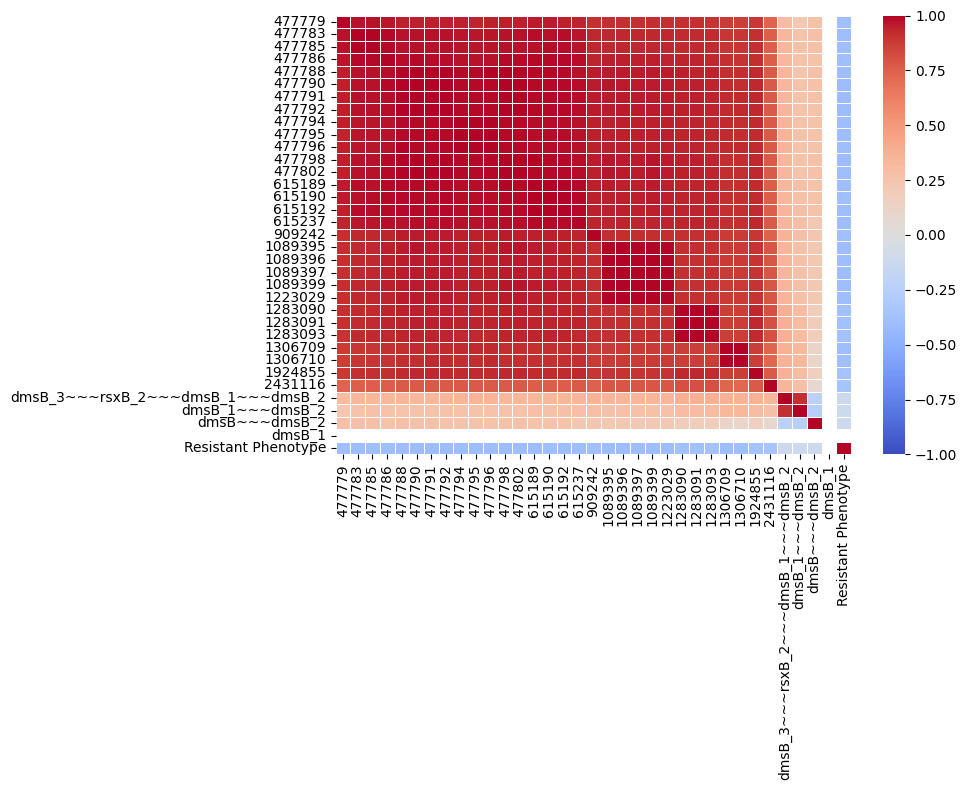

In [307]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    merged.corr(),
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
#plt.title('Ceftriaxone features XGBoost')

plt.tight_layout()
plt.show()

In [293]:
merged.corr()

,477779,477783,477785,477786,477788,477790,477791,477792,477794,477795,...,1283093,1306709,1306710,1924855,2431116,dmsB_3~~~rsxB_2~~~dmsB_1~~~dmsB_2,dmsB_1~~~dmsB_2,dmsB~~~dmsB_2,dmsB_1,Resistant Phenotype
477779,1.000000,0.981065,0.979677,0.970667,0.962820,0.961443,0.960756,0.960756,0.955955,0.955271,...,0.899210,0.859531,0.858287,0.879460,0.698614,0.281759,0.190799,0.252004,NaN,-0.286646
477783,0.981065,1.000000,0.998586,0.989430,0.980214,0.978811,0.978110,0.978110,0.973217,0.972520,...,0.915290,0.874926,0.873658,0.895157,0.710734,0.314975,0.220695,0.256925,NaN,-0.290255
477785,0.979677,0.998586,1.000000,0.990833,0.980206,0.978801,0.978099,0.978099,0.973199,0.972501,...,0.916598,0.874763,0.873493,0.895018,0.711752,0.317439,0.221349,0.257293,NaN,-0.290928
477786,0.970667,0.989430,0.990833,1.000000,0.985147,0.987975,0.987267,0.987267,0.978085,0.977382,...,0.923827,0.883131,0.881851,0.903508,0.717371,0.312943,0.219490,0.250787,NaN,-0.292832
477788,0.962820,0.980214,0.980206,0.985147,1.000000,0.997171,0.997880,0.996465,0.991537,0.992249,...,0.928934,0.894020,0.892745,0.908669,0.721762,0.320732,0.214601,0.261616,NaN,-0.293625
477790,0.961443,0.978811,0.978801,0.987975,0.997171,1.000000,0.999293,0.999293,0.990113,0.989410,...,0.931668,0.895286,0.894009,0.911376,0.724267,0.319916,0.218380,0.253448,NaN,-0.296108
477791,0.960756,0.978110,0.978099,0.987267,0.997880,0.999293,1.000000,0.998585,0.989402,0.990114,...,0.930911,0.895920,0.894642,0.910602,0.723298,0.319508,0.217928,0.253633,NaN,-0.294639
477792,0.960756,0.978110,0.978099,0.987267,0.996465,0.999293,0.998585,1.000000,0.989402,0.988699,...,0.930911,0.895920,0.894642,0.910602,0.723298,0.321149,0.219490,0.250787,NaN,-0.294639
477794,0.955955,0.973217,0.973199,0.978085,0.991537,0.990113,0.989402,0.989402,1.000000,0.999293,...,0.925622,0.893262,0.891977,0.908036,0.725414,0.329786,0.222572,0.240705,NaN,-0.295203
477795,0.955271,0.972520,0.972501,0.977382,0.992249,0.989410,0.990114,0.988699,0.999293,1.000000,...,0.924868,0.893899,0.892613,0.907266,0.724448,0.329379,0.222121,0.240891,NaN,-0.293735


In [299]:
list(merged[(merged['dmsB~~~dmsB_2'].notna()) & (merged[2431116] == 1)].index)

['1328383.3',
 '1328384.3',
 '1328385.3',
 '1328386.3',
 '1328387.3',
 '1438708.3',
 '1438709.3',
 '1438711.3',
 '1438712.3',
 '1438713.3',
 '1438714.3',
 '1438715.3',
 '1438717.3',
 '1438718.3',
 '1438719.3',
 '1438720.3',
 '1438722.3',
 '1438723.3',
 '1438724.3',
 '1438725.3',
 '1438726.3',
 '1438727.3',
 '1438728.3',
 '1438729.3',
 '1438730.3',
 '1438731.3',
 '1438732.3',
 '1438733.3',
 '1438734.3',
 '1438735.3',
 '1438736.3',
 '1438737.3',
 '1438738.3',
 '1438739.3',
 '1438740.3',
 '1438741.3',
 '1438742.3',
 '1438743.3',
 '1438744.3',
 '1438745.3',
 '1438746.3',
 '1438747.3',
 '1438748.3',
 '1438750.3',
 '1438751.3',
 '1438752.3',
 '1438753.3',
 '1438755.3',
 '1438756.3',
 '1438757.3',
 '1438758.3',
 '1438759.3',
 '1438760.3',
 '1438761.3',
 '1438762.3',
 '1438763.3',
 '1438764.3',
 '1438765.3',
 '1438766.3',
 '1438767.3',
 '1438768.3',
 '1438769.3',
 '1438770.3',
 '1438771.3',
 '1438773.3',
 '1438774.3',
 '1438775.3',
 '1438776.3',
 '1438777.3',
 '1438778.3',
 '1438779.3',
 '1438

477779:
573.13034 - gene actually missing/break - found last amino acids
573.13036 - gene actually missing/break - found last amino acids
573.13038 - gene actually missing/break - found last amino acids
573.13041 - gene actually missing/break - found last amino acids
573.13162 - gene actually missing/break - found last amino acids
573.13475 - gene actually missing/break

2431116:
1438772.3 - alternative present


In [ ]:
>Non_fig_no_2431116
MTTQYGFFIDSARCTGCKTCELACKDYKNLTPEVSFRRIYEYAGGDWQEDNGVWQQNVFA
YYLSIACNHCEDPACTKVCPSGAMHKREDGFVVVNEEVCIGCRYCHMACPYGAPQYNADK
GHMTKCDGCHERVAEGKKPICVESCPLRALDFGPIAELRAKHGQLAAVAPLPSAHFTRPS
IVIKPNANARPCGDTTGYLANPKEV

>non_sig
MHKREDGFVVVNEEVCIGCRYCHMACPYGAPQYNADKGHMTKCDGCHERVAEGKKPICVE
SCPLRALDFGPIAELRAKHGQLAAVAPLPSAHFTRPSIVIKPNANARPCGDTTGYLANPK
EV

>non_sig
MSTQYGFFIDSARCTGCKTCELACKDYKNLTPEVSFRRIYEYAGGDWQEDNGVWQQNVFA
YYLSIACNHCEDPACTKVCPSGAMHKREDGFVVVNEEVCIGCRYCHMACPYGAPQYNADK
GHMTKCDGCHERVAEGKKPICVESCPLRALDFGPIAELRAKHSQLAAVAPLPSAHFTRPS
IVIKPNANARPCGDTTGYLANPKEV

>sig
MTTQYGFFIDSARCTGCKTCELACKDYKNLTPEVSFRRIYEYAGGDWQEDNGVWQQNVFA
YYLSIACNHCEDPACTKVCPSGAMHKREDGFVVVNEEVCIGCRYCHMACPYGAPQYNADK
GHMTKCDGCHERVAEGKKPICVESCPLRALDFGPIAELRAKHGQLAAVAPLPSAHFTRPS
IVIKPNANARPCGDTTGYLANPKEV


>Non_sig_bases
ATGCATAAGCGCGAAGACGGTTTTGTGGTGGTCAACGAAGAGGTATGCATTGGCTGCCGC
TACTGCCATATGGCCTGCCCGTACGGCGCCCCGCAGTACAATGCCGACAAAGGCCATATG
ACCAAGTGCGATGGCTGTCACGAGCGTGTCGCCGAGGGGAAAAAGCCGATCTGCGTCGAG
TCCTGCCCGCTGCGGGCGTTGGATTTCGGGCCGATTGCCGAACTGCGCGCTAAGCACGGC
CAGCTGGCCGCGGTAGCGCCGCTGCCGTCGGCGCACTTTACCCGGCCGAGTATCGTTATC
AAACCTAACGCCAATGCCCGGCCGTGTGGCGATACCACCGGTTACCTGGCGAACCCGAAG
GAGGTGTGA

>non_sig
ATGAGCACGCAATATGGATTCTTTATCGACTCCGCTCGCTGTACCGGATGCAAAACCTGC
GAGCTGGCCTGTAAGGACTACAAGAACCTGACTCCGGAGGTCAGCTTCCGCCGGATCTAT
GAGTATGCCGGCGGCGACTGGCAGGAGGACAACGGCGTCTGGCAGCAGAACGTGTTTGCC
TATTACCTCTCCATCGCCTGTAACCACTGTGAAGATCCGGCCTGCACCAAGGTCTGTCCG
AGCGGCGCGATGCATAAGCGCGAAGACGGTTTTGTGGTGGTCAACGAAGAGGTATGCATT
GGCTGCCGCTACTGCCATATGGCCTGCCCGTACGGCGCCCCGCAGTACAACGCCGACAAA
GGCCATATGACCAAATGCGATGGCTGTCACGAGCGCGTCGCCGAGGGGAAAAAGCCGATC
TGCGTCGAGTCCTGCCCGCTGCGGGCGTTGGATTTCGGGCCAATTGCCGAACTGCGCGCT
AAGCATAGCCAGCTGGCCGCGGTAGCGCCGCTGCCGTCGGCGCACTTTACCCGGCCGAGT
ATCGTTATCAAACCTAACGCCAATGCCCGGCCGTGTGGCGATACCACCGGTTACCTGGCG
AACCCGAAGGAGGTGTGA


>sig
ATGACAACTCAGTATGGATTTTTTATTGATTCCGCCCGTTGCACCGGTTGCAAAACCTGC
GAACTGGCCTGTAAGGACTACAAGAACCTGACCCCGGAGGTCAGCTTCCGCCGCATCTAT
GAATATGCCGGCGGCGACTGGCAGGAGGACAACGGCGTCTGGCAGCAGAACGTGTTTGCC
TATTACCTCTCAATCGCCTGTAACCACTGTGAAGATCCGGCCTGCACCAAGGTCTGTCCG
AGCGGCGCGATGCATAAGCGCGAAGACGGTTTTGTGGTGGTCAACGAAGAGGTATGCATT
GGCTGCCGCTACTGCCATATGGCCTGCCCGTACGGCGCCCCACAGTACAACGCCGACAAA
GGCCATATGACCAAGTGCGATGGCTGTCACGAGCGCGTCGCCGAGGGGAAAAAGCCGATC
TGCGTCGAGTCCTGCCCGCTGCGGGCGTTGGATTTCGGGCCGATTGCCGAACTGCGCGCT
AAGCACGGCCAGCTGGCCGCGGTAGCGCCGCTGCCGTCGGCGCACTTTACCCGGCCGAGT
ATCGTTATCAAACCTAACGCCAATGCCCGGCCGTGTGGCGATACCACCGGTTACCTGGCG
AACCCGAAGGAGGTGTGA


In [300]:
420/3

140.0

In [ ]:
def map_to_all_features(intersection):
    import pandas as pd
    import subprocess
    unitigs = intersection
    feature_number = [int(x) + 1 for x in unitigs]
    strings = []
    mapping = {}
    for feature in feature_number:
        filepath = "/home/kvk22/rds/rds-kleb-oUtDW8q9d2A/genomes/genomes_PATRIC/DBGWAS/all/step1/bugwas_input.unique_rows_to_all_rows.binary"
        command = f'sed -n {feature}p {filepath}'
        # Execute the command
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        result = result.stdout.strip().split(" ")
        print(f' Original feature {feature-1}, mapped to: {result}')
        strings.append(result)
        for i in result:
            mapping[i] = feature-1
    flattened_list = [item for sublist in strings for item in sublist]
    flattened_list_added = [int(x) + 1 for x in flattened_list]
    strings = []
    for feature in flattened_list_added:
        filepath = "/home/kvk22/rds/rds-kleb-oUtDW8q9d2A/genomes/genomes_PATRIC/DBGWAS/all/step1/graph.nodes"
        command = f'sed -n {feature}p {filepath}'
        # Execute the command
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        result = result.stdout.strip()
        strings.append(result)
        print(result)
    

In [233]:
# Find indexes where 'dmsB_1~~~dmsB_2' is not NA and 477788 is 0 in merged
list(merged[(merged['dmsB_3~~~rsxB_2~~~dmsB_1~~~dmsB_2'].notna()) & (merged[477788] == 0)].index)

['573.13031',
 '573.13032',
 '573.13033',
 '573.13034',
 '573.13035',
 '573.13036',
 '573.13037',
 '573.13038',
 '573.13039',
 '573.13041',
 '573.13042',
 '573.13043',
 '573.13044',
 '573.13045',
 '573.13046',
 '573.13048',
 '573.13049',
 '573.13051',
 '573.13052',
 '573.13053',
 '573.13054',
 '573.13055',
 '573.13056',
 '573.13057',
 '573.13058',
 '573.13059',
 '573.13061',
 '573.13062',
 '573.13064',
 '573.13065',
 '573.13067',
 '573.13068',
 '573.13069',
 '573.13073',
 '573.13074',
 '573.13075',
 '573.13076',
 '573.13077',
 '573.13079',
 '573.13081',
 '573.13082',
 '573.13083',
 '573.13084',
 '573.13085',
 '573.13087',
 '573.13089',
 '573.13092',
 '573.13093',
 '573.13094',
 '573.13095',
 '573.13096',
 '573.13097',
 '573.13098',
 '573.13099',
 '573.13101',
 '573.13102',
 '573.13103',
 '573.13104',
 '573.13105',
 '573.13106',
 '573.13107',
 '573.13108',
 '573.13109',
 '573.13111',
 '573.13112',
 '573.13113',
 '573.13114',
 '573.13115',
 '573.13116',
 '573.13117',
 '573.13118',
 '573.

In [230]:
merged.T["573.32133.fna"]

dmsB_3~~~rsxB_2~~~dmsB_1~~~dmsB_2    2379_refound_100611
dmsB_1~~~dmsB_2                      2379_refound_100608
dmsB~~~dmsB_2                                        NaN
dmsB_1                                               NaN
477788                                                 0
Name: 573.32133.fna, dtype: object

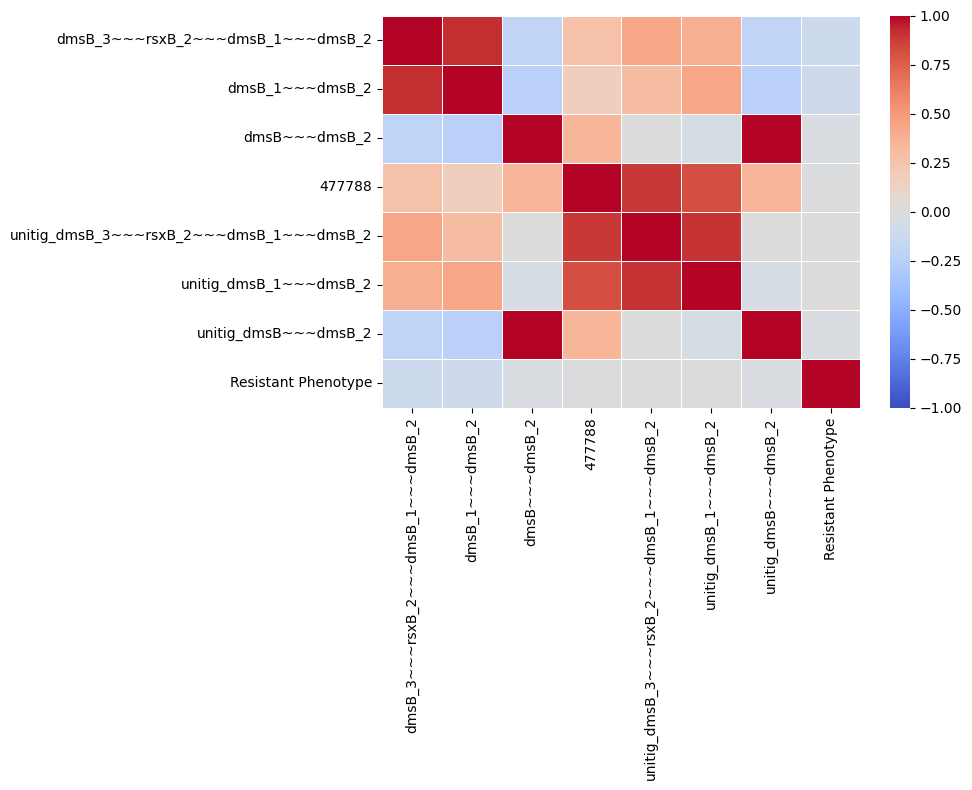

In [216]:
merged.drop(columns=["unitig_dmsB_1"], inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(
    merged.corr(),
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
#plt.title('Ceftriaxone features XGBoost')

plt.tight_layout()
plt.show()

In [213]:
merged

,dmsB_3~~~rsxB_2~~~dmsB_1~~~dmsB_2,dmsB_1~~~dmsB_2,dmsB~~~dmsB_2,dmsB_1,477788,unitig_dmsB_3~~~rsxB_2~~~dmsB_1~~~dmsB_2,unitig_dmsB_1~~~dmsB_2,unitig_dmsB~~~dmsB_2,unitig_dmsB_1,Resistant Phenotype
573.12858,1,1,0,0,1,1,1,0,0,1
573.12859,1,1,0,0,1,1,1,0,0,0
573.12861,1,1,0,0,1,1,1,0,0,0
573.12862,1,1,1,0,1,1,1,1,0,0
573.12863,1,1,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
573.7031,1,1,0,0,1,1,1,0,0,1
573.7032,1,1,0,0,1,1,1,0,0,1
573.7033,1,1,0,0,1,1,1,0,0,0
574.26,1,1,0,0,1,1,1,0,0,1


In [185]:
#find the feature in other samples 
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
#columns_with_entry = gene_presence_absence.columns[gene_presence_absence.isin(["EFGKMKNF_00652"]).any()]
#rows_with_entry = gene_presence_absence[gene_presence_absence.isin(["EFGKMKNF_00652"]).any(axis=1)]
# Extract columns from gene_presence_absence whose names contain 'dmsB'
gene_presence_absence.index = gene_presence_absence["Gene"]
# Find all index values in gene_presence_absence that contain 'dmsb' (case-insensitive)
dmsB_indices = [idx for idx in gene_presence_absence.index if 'dmsb' in str(idx).lower()]
dmsB_rows = gene_presence_absence.loc[dmsB_indices]

/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_30351/3847804489.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [186]:
dmsB_rows

,Gene,Non-unique Gene name,Annotation,1328382.3.fna,1328383.3.fna,1328384.3.fna,1328385.3.fna,1328386.3.fna,1328387.3.fna,1438708.3.fna,...,72407.588.fna,72407.589.fna,72407.591.fna,72407.592.fna,72407.593.fna,72407.594.fna,72407.595.fna,72407.596.fna,72407.597.fna,72407.698.fna
Gene,,,,,,,,,,,,,,,,,,,,,
dmsB_3~~~rsxB_2~~~dmsB_1~~~dmsB_2,dmsB_3~~~rsxB_2~~~dmsB_1~~~dmsB_2,dmsB_3;rsxB_2;dmsB_1;dmsB_2,Anaerobic dimethyl sulfoxide reductase chain B...,IOPHDDBF_00729,EFGKMKNF_01067,FIKJNJIK_03399,DKIEGJMK_01014,AIJNNKPI_04654,PDBBJNHL_01529,BNBLALMK_03952,...,OLDBLFCI_01646,EHGCAHME_00220,PCNGDBMH_00824,3253_refound_139106_pseudo,3254_refound_139166,3255_refound_139223,KCFLOIMA_01457,HEBEEKHE_00957,FMBKNBNK_01851,EBNGODPG_01950
dmsB_1~~~dmsB_2,dmsB_1~~~dmsB_2,dmsB_1;dmsB_2,Anaerobic dimethyl sulfoxide reductase chain B,IOPHDDBF_01414,EFGKMKNF_01633,FIKJNJIK_02801,DKIEGJMK_01651,AIJNNKPI_00176,PDBBJNHL_02220,BNBLALMK_04643,...,OLDBLFCI_00035,NaN,NaN,BEMACLBI_05327,ELBIKAFO_04854,PPPMIFOE_03523,KCFLOIMA_00423,HEBEEKHE_00384,FMBKNBNK_00868,NaN
dmsB~~~dmsB_2,dmsB~~~dmsB_2,dmsB;dmsB_2,Anaerobic dimethyl sulfoxide reductase chain B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3251_refound_138724_pseudo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dmsB_1,dmsB_1,dmsB_1,Anaerobic dimethyl sulfoxide reductase chain B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
>absent_unitig_beginning of dmsB
cccgtcttcgcgcttatgcatcgcgccgctcggacagaccttggtgcaggccggatcttc
acagtggttacaggcgattgagaggtaataggcaaacacgttctgctgccagacgccgtt
gtcctcctgccagtcgccgccggcatattcatagatgcggcggaagctgacctccggggt
caggttcttgtagtccttacaggccagttcgcaggttttgcaaccggtgcaacgggcgga
atcaataaaaaatccatactgagttgtcatcggttactccttacagctt


>present unitig end of dmsB

,marA_2~~~soxS_3~~~soxS_1~~~marA_1~~~rhaR_6,1667507,unitig_gene,Resistant Phenotype
marA_2~~~soxS_3~~~soxS_1~~~marA_1~~~rhaR_6,1.000000,0.727460,0.744385,-0.090257
1667507,0.727460,1.000000,0.990718,-0.067440
unitig_gene,0.744385,0.990718,1.000000,-0.062193
Resistant Phenotype,-0.090257,-0.067440,-0.062193,1.000000


In [52]:
#get the unitig
replicating_features = [1894441]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
replicating_features_frame = replicating_features_frame.T
#replicating_features_frame = 1 - replicating_features_frame

#load amr phenotype 
phenotype= "/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My Drive/metadata/Patric_AMR_data"
AMR = pd.read_csv(phenotype)
AMR = AMR[AMR["Antibiotic"] == "ceftriaxone"]
AMR["Resistant Phenotype"] = np.where(AMR["Resistant Phenotype"] == 'Susceptible', 0, 1)
AMR = AMR[["Genome ID", "Resistant Phenotype"]]
AMR = AMR.drop_duplicates(subset="Genome ID")
AMR.set_index("Genome ID", inplace=True)
replicating_features_frame.index = replicating_features_frame.index.str.replace(".fna", "", regex=False)
AMR.index = AMR.index.astype(str)
merged = pd.merge(replicating_features_frame, AMR, left_index=True, right_index=True, how='inner')

#subset non-Klebs 
Kleborate="/Users/kvk22/Library/CloudStorage/GoogleDrive-kvk22@cam.ac.uk/My Drive/metadata/concatinated_Kleborate.txt"
Kleb = pd.read_csv(Kleborate, delimiter = "\t")
Kleb = Kleb[Kleb["species"] == "Klebsiella pneumoniae"]
Kleb["strain"] = Kleb["strain"].astype(str)
Kleb["strain"].replace(".fna", "", inplace = True)
merged = merged[merged.index.isin(Kleb["strain"])]

#load annotation
annotation_tool = "Kleborate"
annotations=f"/Users/kvk22/Downloads/{annotation_tool}_annotations.csv"
annotations = pd.read_csv(annotations, low_memory=False)
annotations["strain"] = annotations["strain"].astype(str)
annotations["strain"] = annotations["strain"].str.replace(".fna", "")
merged = merged[merged.index.isin(annotations["strain"])]

/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_2323/167275608.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Kleb["strain"].replace(".fna", "", inplace = True)


In [53]:
merged.corr()

,1894441,Resistant Phenotype
1894441,1.000000,0.163186
Resistant Phenotype,0.163186,1.000000


In [ ]:
#find the feature in other samples 
gene_presence_absence = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/genomes/gene_presence_absence.csv")
columns_with_entry = gene_presence_absence.columns[gene_presence_absence.isin(["IPGPDFDI_04694"]).any()]
rows_with_entry = gene_presence_absence[gene_presence_absence.isin(["IPGPDFDI_04694"]).any(axis=1)]
rows_with_entry.index = rows_with_entry["Gene"]
gene = rows_with_entry["Gene"].values[0]
cols_to_drop = [col for col in ["Gene", "Non-unique Gene name", "Annotation"] if col in gene_presence_absence.columns]
rows_with_entry = rows_with_entry.drop(columns=cols_to_drop)
#rows_with_entry = rows_with_entry.notna().astype(int)

#get the unitig
replicating_features = [597806]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
#replicating_features_frame = 1 - replicating_features_frame

merged = pd.merge(rows_with_entry.T, replicating_features_frame.T, left_index=True, right_index=True, how='inner')
merged

/var/folders/fq/yr8b6_ts7jq24_grrhz5kfm80000gp/T/ipykernel_2323/2250432257.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,

,group_16798,597806
1328383.3.fna,NaN,0
1328384.3.fna,NaN,0
1328385.3.fna,NaN,0
1328386.3.fna,NaN,0
1328387.3.fna,NaN,0
...,...,...
72407.594.fna,NaN,0
72407.595.fna,NaN,0
72407.596.fna,NaN,0
72407.597.fna,NaN,0


In [24]:
merged[merged["group_16798"].notna()]

,group_16798,597806
1438749.3.fna,JAOCBNCB_02609,0
1438754.3.fna,GGFEMGIH_02819,0
573.12867.fna,IIBNMKAF_04947,0
573.12869.fna,GCFGOLJJ_04936,0
573.12874.fna,FAECAPPB_04776,0
...,...,...
72407.542.fna,APDCCFKE_00816,0
72407.546.fna,JBPNMAJN_01652,0
72407.547.fna,ELLKJBNB_00001,0
72407.552.fna,ECHAKFIL_00889,0


In [216]:
import os

folder = "/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/Arthemis/annotations"
files = os.listdir(folder)
files = [f.replace(".gff", "") for f in files]
files

['573.66226.fna',
 '573.12968.fna',
 '573.12872.fna',
 '573.12862.fna',
 '573.12947.fna',
 '1438730.3.fna',
 '573.24328.fna',
 '573.15616.fna',
 '1328413.3.fna',
 '1438708.3.fna',
 '573.12913.fna',
 '573.13162.fna',
 '1438772.3.fna',
 '1328384.3.fna',
 '573.12971.fna',
 '573.12985.fna',
 '573.13282.fna',
 '573.13398.fna',
 '573.15463.fna',
 '1328401.3.fna',
 '1328415.3.fna',
 '.DS_Store',
 '72407.695.fna',
 '573.13034.fna',
 '573.13046.fna',
 '573.66227.fna',
 '573.66462.fna',
 '1329843.3.fna',
 '573.12863.fna',
 '573.12887.fna',
 '573.12897.fna',
 '1328427.3.fna',
 '72407.697.fna',
 '573.24322.fna',
 '573.13054.fna',
 '573.13044.fna',
 '573.66309.fna',
 '1328406.3.fna',
 '573.13036.fna',
 '1400162.3.fna',
 '1328385.3.fna',
 '573.5805.fna',
 '573.13243.fna',
 '573.13037.fna 2',
 '573.12954.fna',
 '573.12944.fna',
 '573.23196.fna',
 '1438737.3.fna',
 'core_gene_alignment_snps.aln',
 '573.13475.fna',
 '573.66311.fna',
 '573.12945.fna',
 '573.12894.fna',
 '573.13252.fna',
 '573.26079.fna'

In [ ]:
merged_sub = merged[merged[477796] ==1]
merged_sub = merged_sub[merged_sub.index.isin(files)]
merged_sub.to_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/Arthemis/Cefuroxime_uncharacterised_location.csv")

In [226]:
#get the unitig
replicating_features = [2431611]
replicating_features =  [int(feature) for feature in replicating_features]
all_features = set(range(0,5458393))
rows_to_skip = all_features - set(replicating_features)
rows_to_skip = rows_to_skip 
rows_to_skip = list(rows_to_skip)
rows_to_skip = [x+1 for x in rows_to_skip]            
replicating_features_frame = pd.read_csv("/Users/kvk22/Library/CloudStorage/OneDrive-UniversityofCambridge/Desktop/DBGWAS/bugwas_input.unique_rows.binary", sep=' ',  skiprows = rows_to_skip, index_col= "ps")
replicating_features_frame.columns[(replicating_features_frame == 0).any(axis=0)]

Index(['1328415.3.fna', '1328424.3.fna', '1328425.3.fna', '1328427.3.fna',
       '1438727.3.fna', '1438749.3.fna', '1438754.3.fna', '1438764.3.fna',
       '1438765.3.fna', '1438771.3.fna',
       ...
       '72407.692.fna', '72407.695.fna', '72407.697.fna', '72407.698.fna',
       '72407.703.fna', '72407.704.fna', '72407.705.fna', '72407.706.fna',
       '72407.716.fna', '72407.732.fna'],
      dtype='object', length=1904)

In [ ]:
>significant
MRYIRLCIISLLATLPLAVHASPQPLEQIKQSESQLSGRVGMIEMDLASGRTLTAWRADE
RFPMMSTFKVVLCGAVLARVDAGDEQLERKIHYRQQDLVDYSPVSEKHLADGMTVGELCA
AAITMSDNSAANLLLATVGGPAGLTAFLRQIGDNVTRLDRWETELNEALPGDARDTTTPA
SMAATLRKLLTSQRLSARSQRQLLQWMVDDRVAGPLIRSVLPAGWFIADKTGASKRGARG
IVALLGPNNKAERIVVIYLRDTPASMAERNQQIAGIGAALIEHWQR

>significant
ATGCGTTATATTCGCCTGTGTATTATCTCCCTGTTAGCCACCCTGCCGCTGGCGGTACAC
GCCAGCCCGCAGCCGCTTGAGCAAATTAAACAAAGCGAAAGCCAGCTGTCGGGCCGCGTA
GGCATGATAGAAATGGATCTGGCCAGCGGCCGCACGCTGACCGCCTGGCGCGCCGATGAA
CGCTTTCCCATGATGAGCACCTTTAAAGTAGTGCTCTGCGGCGCAGTGCTGGCGCGGGTG
GATGCCGGTGACGAACAGCTGGAGCGAAAGATCCACTATCGCCAGCAGGATCTGGTGGAC
TACTCGCCGGTCAGCGAAAAACACCTTGCCGACGGCATGACGGTCGGCGAACTCTGCGCC
GCCGCCATTACCATGAGCGATAACAGCGCCGCCAATCTGCTGCTGGCCACCGTCGGCGGC
CCCGCAGGATTGACTGCCTTTTTGCGCCAGATCGGCGACAACGTCACCCGCCTTGACCGC
TGGGAAACGGAACTGAATGAGGCGCTTCCCGGCGACGCCCGCGACACCACTACCCCGGCC
AGCATGGCCGCGACCCTGCGCAAGCTGCTGACCAGCCAGCGTCTGAGCGCCCGTTCGCAA
CGGCAGCTGCTGCAGTGGATGGTGGACGATCGGGTCGCCGGACCGTTGATCCGCTCCGTG
CTGCCGGCGGGCTGGTTTATCGCCGATAAGACCGGAGCTAGCAAGCGGGGTGCGCGCGGG
ATTGTCGCCCTGCTTGGCCCGAATAACAAAGCAGAGCGCATTGTGGTGATTTATCTGCGG
GATACGCCGGCGAGCATGGCCGAGCGAAATCAGCAAATCGCCGGGATCGGCGCGGCGCTG
ATCGAGCACTGGCAACGCTAA


GCTAGCTCCGGTCTTATCGGCGATAAACCAGCC

>Non_significant


>Non_significant

